In [2]:
# Downloads the MNIST data set directly from the TensorFlow and Keras API. The MNIST dataset contains 60,000 training images
# and 10,000 testing images (with accompanying labels). We separate these two groups into train_imgs and train_labels for the training
# images and training labels, respectively, and test_imgs and test_labels for the test images and test labels respectively
(train_imgs, train_labels), (test_imgs, test_labels) = mnist.load_data()

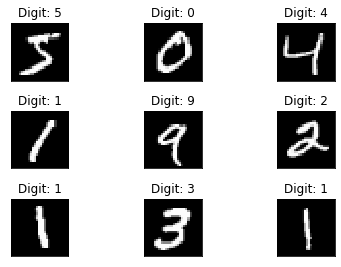

In [4]:
# Creates a new figure
plt.figure()

# Displays 9 digits
for i in range(9):
    # Add a subplot to the current figure
    plt.subplot(3, 3, i + 1)
    
    # Provides routines to adjust subplot params so that subplots are nicely fit in the figure
    plt.tight_layout()
    
    # Displays training images at index i, colormap of gray, and 
    plt.imshow(train_imgs[i], cmap='gray', interpolation='none')
    
    # Adds a title to each digit
    plt.title("Digit: {}".format(train_labels[i]))
    
    # Get or set the current tick locations and labels of the x-axis
    plt.xticks([])
    
    # Get or set the current tick locations and labels of the y-axis
    plt.yticks([])
    
# Display a figure    
plt.show()

In [3]:
# Print data shapes
print("Training digits shape: ", train_imgs.shape)
print("Training labels shape: ", train_labels.shape)
print("Testing digits shape: ", test_imgs.shape)
print("Testing labels shape: ", test_labels.shape)

Training digits shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Testing digits shape:  (10000, 28, 28)
Testing labels shape:  (10000,)


In [4]:
# Defines the size of the image as 28 * 28 pixels
img_rows, img_cols = 28, 28

In [5]:
# Reshaping
#
# To be able to use the MNIST dataset with the Keras API, we need to change our array (which is 3-dimensional)
# to 4-dimensional numpy arrays

# https://stackoverflow.com/questions/49057149/expected-conv2d-1-input-to-have-shape-28-28-1-but-got-array-with-shape-1-2
if kBackend.image_data_format() == 'channels_first':
    train_imgs = train_imgs.reshape(train_imgs.shape[0], 1, img_rows, img_cols)
    test_imgs = test_imgs.reshape(test_imgs.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_imgs = train_imgs.reshape(train_imgs.shape[0], img_rows, img_cols, 1)
    test_imgs = test_imgs.reshape(test_imgs.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# Print number of training and testing samples
print(train_imgs.shape[0], 'training samples')
print(test_imgs.shape[0], 'testing samples')

60000 training samples
10000 testing samples


In [6]:
# Ensure the values of train_imgs and test_imgs are float. This is done so as we can get decimal points after division
train_imgs = train_imgs.astype('float32')
test_imgs = test_imgs.astype('float32')

# We also must 'normalize' our data, as is always required in neural networks.
# This can be done by dividing the RGB codes of the images to 255
train_imgs /= 255
test_imgs /= 255

In [7]:
# In the model, we can experiment with any number for the first Dense layer. However, the final Dense layer must have
# 10 neurons since there are 10 number classes (0, 1, 2, 3, ..., 9)
num_classes = 10

# Used to determine the rate of dropout in the below Dropout layers
firstDropout = 0.25
secondDropout = 0.5

train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [8]:
# Create a Sequential model and add the layers. The Sequential model is a linear stack of layers.
model = Sequential()

# This particular model has 8 layers

# Activation - In the first, second, sixth, and eighth, we use a parameter called 'activation'. This computation decides
# whether a neuron should be activated or not by calculating weighted sum and further adding bias with it. The purpose 
# of the activation function is to introduce non-linearity into the output of a neuron. Sigmoid, Tanh/Hyperbolic, and 
# ReLu (Rectified Linear Unit), and Softmax are types of activation

# This layer, and the layer below, creates a convolution kernel that is convolved with the layer input to produce a tensor of 
# outputs. This first convolutional layer adds 32 convolution filters and a kernel size of 3 x 3
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))

# This first convolutional layer adds 64 convolution filters and a kernel size of 3 x 3
model.add(Conv2D(64, (3, 3), activation='relu'))

# Max pooling operation for spatial data. When constructing CNNs, it is common to insert pooling layers after each convolution 
# layer (above) to reduce the spatial size of the representation to reduce the parameter counts which reduces the computational 
# complexity. Basically, we do this to choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# A simple and powerful regularization technique for neural networks and deep learning models is dropout. Dropout 
# is a technique where randomly selected neurons are ignored during training. This means that their contribution
# to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied 
# to the neuron on the backward pass.The randomly selected number of neurons that are ignored during training are based 
# on the dropout rate we apply
model.add(Dropout(firstDropout))

# Flattens the 2D arrays for fully connected layers. Since there are too many dimensions, we use Flatten as we only want a 
# classification output
model.add(Flatten()) 

# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
# Ususally, when using the Dense layer, you would specify the input shape. However, as we have already done this in the first
# layer, there is no need to do this 
# Outputs an array of shape (*, 128)
model.add(Dense(128, activation='relu'))

#  We perform one more droput for the sake of convergence
model.add(Dropout(secondDropout))

# Softmax turns numbers aka logits into probabilities that sum to one. Output a softmax to squash the matrix into output 
# probabilities
# Outputs an array of shape (*, num_classes)
model.add(Dense(num_classes, activation='softmax'))

# Adaptive learning rate (Adadelta) is a popular form of gradient descent rivaled only by adam and adagrad
# We specify the loss as catergorical_crossentropy as we have multiple classes (10)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [9]:
# Determines the number of samples that will be propagated through the neural network
batch_size = 128

# In the context of a neural network, one epoch is the equivalent of one forward pass and one backward pass of
# all the training examples

# With this model, the model seems to peak (in terms of accuracy) at 20 epochs. Any more epochs after this is more or less overkill
num_epoch = 10

# To avoid having to train the model each time the program is ran, the trained model can be loaded from a file
# If no file has been created, then the model is trained and then saved to a file. For the purposes of this notebook, 
# the model will be trained each time

# try:
#     print("Model loaded successfully")
#     model = load_model("model.h5")
# except:
#     print("Failed to load model. Creating new model...")
model_log = model.fit(train_imgs, train_labels,
                          batch_size=batch_size,
                          epochs=num_epoch,
                          verbose=1,
                          validation_data=(test_imgs, test_labels))

model.save_weights("model.h5")

model.save("model.h5")
print("Saved model. Model will now be loaded on next run through")

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.2711 - accuracy: 0.9166 - val_loss: 0.0598 - val_accuracy: 0.9807
Epoch 2/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0923 - accuracy: 0.9726 - val_loss: 0.0444 - val_accuracy: 0.9845
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0686 - accuracy: 0.9796 - val_loss: 0.0383 - val_accuracy: 0.9866
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0566 - accuracy: 0.9828 - val_loss: 0.0291 - val_accuracy: 0.9897
Epoch 5/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0481 - accuracy: 0.9860 - val_loss: 0.0292 - val_accuracy: 0.9900
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0284 - val_accuracy: 0.9910
Epoch 7/10
60000/60000 [==============================] - 86s 1ms/st

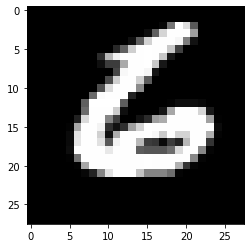

[[2.7962891e-08 2.5915032e-11 1.2977638e-08 4.7781459e-11 7.0392893e-08
  6.1974525e-08 9.9999988e-01 2.2648092e-13 3.9686959e-10 5.4808363e-11]] 

Predicted number:  6


In [10]:
plt.imshow(test_imgs[9999].reshape(28, 28), cmap="gray")
plt.show()

print(model.predict(test_imgs[9999:10000]), "\n\nPredicted number: ", np.argmax(model.predict(test_imgs[9999:10000])))